# Part 1

# 1.1

a) Usually, if we know what we are doing, when we build a model we have it living in a feature space and that is no exception to linear models. Now if we decide to use the natural feature space for linear models we are limiting ourselves in some way: we will be able to reconstruct only linear structures, which more often then not is not enough to create good, solid models able to describe realistic phenomena. To overcome this issue what we need to do is *transform* the original feature, but how? We can get as creative as we want, indeed our transformation doesn't necessarily need to be linear. For the case of polynomials we will have then created an **artificial feature space** $[\phi_1(x),...,\phi_p(x)]^T$, where $p=degree(poly)+1$. In this way we are able to approximate also non linear models (as long as $\phi$ is defined accordingly).





b) Approximating a function $f$ using a basis $\{ \phi_j \}_j$ means to project $f$ over the span of the $\phi_j$s vectors. Here we can look at the generic meaning of a series expansion: being able to proxy the function $f$ by 
$$
f=\sum_j \beta_j \phi_j
$$
With this representation it's obvious that using an orthonormal basis is far more convenient than using a randomly chosen basis (of course it has to satisfy some properties to be a basis) because it allows to easily determine the $\beta_j$ coefficients. So to wrap up the answer to your question we can say that the 'spirit' (or idea) used for the expansion is conceptually the same, but we are not making use of an orthonormal basis in the splines example. Now please don't ask what would happen if we did use it...

## IMPORTS

In [9]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

In [10]:
#Import data
data=pd.read_csv('wmap.csv')

## Functions

Here we define the function generating the Power Function $G_{d,q}$ as defined in the homework assignment and then plot some of its elements for d=1, q=3 in the open interval $(0,1)$.

In [11]:
def power_func(x,d,q):
    #Generate power function for given d,q
    #list in which we store g_i's
    G=[]
    #convert to array
    x=np.array(x)
    j=1
    
    #cicle to assign single g_i's
    for i in range(0,(d+1+q)):
        if i<(d+1):
            G.append(x**i)
        else:
            #split interval of x axis by q points
            sottr=(x[-1]-x[0])/(q+1)*j 
            G.append((np.maximum(0,x-sottr))**d)
            j+=1
            
    return G

In the following we report the functions used to realize different analyses on our data, we'll talk about each of them in the respective section.

In [12]:
def pre_processing(x,d,q):
    #Generates matrix X (in homework assignment) from power function
    mat=power_func(x,d,q)
    mat=np.array(mat)
    return np.transpose(mat)

In [5]:
def GCV_score (d,q,x=data.x,y=data.y):
    #Computes GCV score using splines
    
    #Generate X
    X = pre_processing(x,d,q)
    #Fit model on data
    plm = LinearRegression(fit_intercept=False).fit(X,data.y)
    #Make predictions
    Y_hat = plm.predict(X)
    #Compute MSE
    MSE_tr = mean_squared_error(y,Y_hat)
    #and GCV score
    GCV_score=MSE_tr/((1-((d+1)/len(x)))**2)
    return GCV_score

In [6]:
def assign_folds(k,d=data):
    #Generates k folds using stratified sampling for given pandas dataframe
    
    #k=n_folds>1
    if k<=1:
        raise TypeError("Only integers >1 are allowed") 
    
    #Here we store the folds
    folds=[]
    
    #Assign classes (for stratified sampling)
    d.loc[0:399,'class']=0
    d.loc[400:900,'class']=1
    d=d.astype({'class':int})
    
    #Assign a column to determine whether a row has already been used or not (avoid sampling twice the same row)
    d.loc[0:900,'picked'] = 0

    #Create folds
    for i in range(k):
        #sample 1/k rows of the initial dataframe (the '-i' solves the problem related to the fact we are reducing the size of 
        #the dataframe at each iteration because we only consider rows with 'picked'==0)
        sample=d[d['picked']==0].groupby('class', group_keys=False).apply(lambda x: x.sample(frac=1/(k-i))) 
        #set to 1 the picked rows
        d.loc[sample.index,'picked']=1
        #save the single fold
        folds.append(sample)   
        
    return (folds)

In [7]:
def SCV_score(d,q,k,df):
    #Computes the score for the stratified cross validation (SCV)
    
    #assign folds
    folds=assign_folds(k,df)
    #save results
    SCV=[]
    
    for i in range(len(folds)):
        val=folds[i]
        #Remove rows of the single folder (we need it for the testing)
        tr=df.drop(val.index)
        #just a simple renaming
        x=tr.x
        y=tr.y
        #same here
        x_out=val.x
        y_out=val.y
        
        #generate matrix X to train the model
        X = pre_processing(x,d,q)
        #generate matrix X_out to make predictions using the model
        X_out = pre_processing(x_out,d,q)
        #train model
        plm = LinearRegression(fit_intercept=False).fit(X,y)
        
        #make prediction
        Y_hat = plm.predict(X_out)
        #compute and store MSE value
        MSE_cv = mean_squared_error(y_out,Y_hat)
        SCV.append(MSE_cv)
    return np.mean(SCV)

In [8]:
def CP_score(d,q,x,y):
    #Computes the score for the Mallows' CP
    
    #generate X
    X = pre_processing(x,d,q)
    #train model
    plm = LinearRegression(fit_intercept=False).fit(X,y)
    #predict
    Y_hat = plm.predict(X)
    #compute residuals
    sigma_sq = np.sum((Y_hat-data.y)**2)/(len(x)-d+1)
    #and mse
    MSE_tr = mean_squared_error(y,Y_hat)
    #compute CP
    CP=MSE_tr+ 2*sigma_sq*(d+1)/len(x)
    return CP

In [9]:
def main(d,q,type_,df):
    #returns requested score by specifying variable type_
    x=df.x
    y=df.y
    if type_=='GCV':
        scores=GCV_score(d,q,x,y)
    elif type_=='SCV':
        scores=SCV_score(d,q,10,df)
    elif type_== 'CP':
        scores = CP_score(d,q,x,y)
    return round(scores,2)

## 1.2 - Plotting of power function

In [35]:
x=list(np.linspace(0,1,1000))
G1=power_func(x,1,3)
G3=power_func(x,3,3)

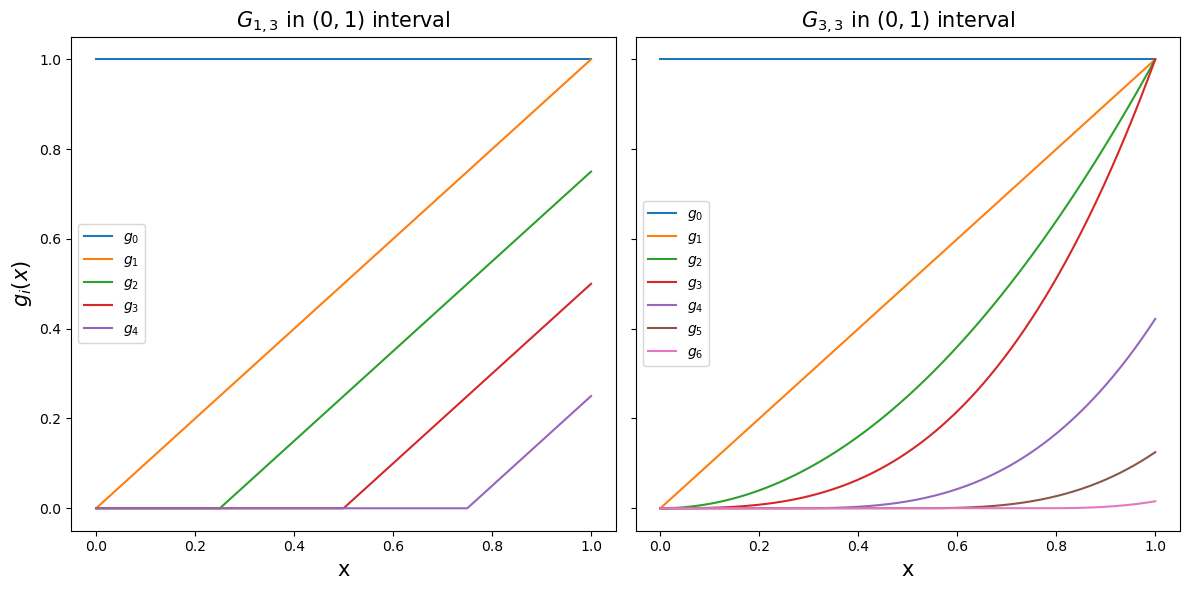

In [40]:
#Plot the loss function
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,6))

for i in range(0,5):
    ax1.plot(x, G1[i], label =(r"$g_{}$").format(i))
for i in range(0,7):    
    ax2.plot(x, G3[i], label =(r"$g_{}$").format(i))
    
ax1.set_title(r'$G_{1,3}$ in $(0,1)$ interval',fontsize=15)
ax1.set_xlabel('x',fontsize=15)
ax1.set_ylabel(r'$g_i(x)$',fontsize=15)

ax2.set_title(r'$G_{3,3}$ in $(0,1)$ interval',fontsize=15)
ax2.set_xlabel('x',fontsize=15)


ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()



## 1.3

To compute the GCV score as requested in part 1.3 of the homework we chose to fix the value of d while searching for score minima evaluating for different q's.

### GCV

#### d=3

In [26]:
d=3

Optimal q in (1,20) for d = 3 is q = 19, with residuals score = 9107396.91


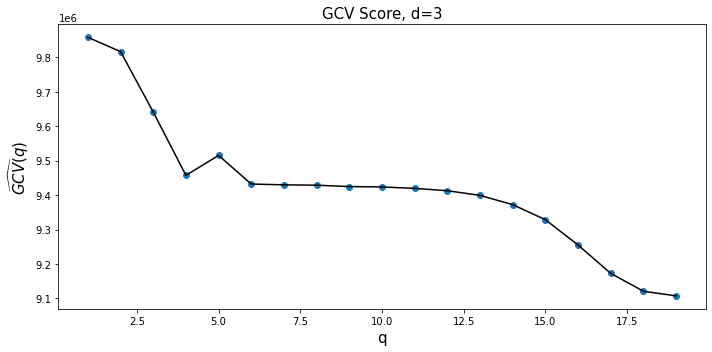

In [47]:
#We chose to take  knots in range (1,20) and look for minima in there
knots=list(range(1,20))
#apply the GCV method to data making q vary
res=list(map(main,[d]*len(knots),knots,['GCV']*len(knots),[data]*len(knots)))
#retrieve index of min value for residuals
ind=np.argmin(res)

print(('Optimal q in (1,20) for d = 3 is q = {}, with residuals score = {}').format(knots[ind],res[ind]))

plt.figure(figsize=(10,5))
plt.scatter(knots,res)
plt.plot(knots,res,color='black')
plt.title(r'GCV Score, d=3',fontsize=15)
plt.xlabel('q',fontsize=15)
plt.ylabel(r'$\widehat{GCV}(q)$',fontsize=15)
plt.tight_layout()
plt.show()

#### d=1

In [48]:
d=1

Optimal q in (1,20) for d = 1 is q = 18, with residuals score = 9324213.82


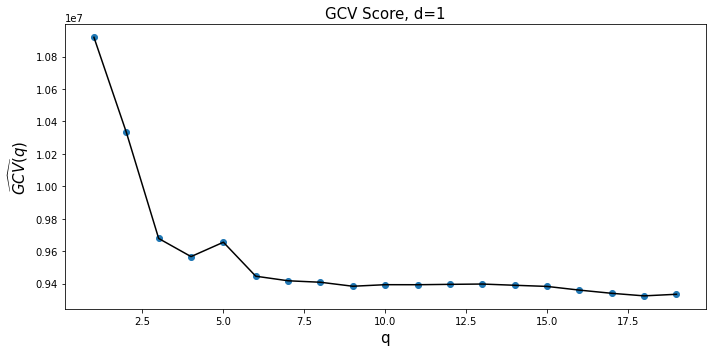

In [49]:
#We chose to take  knots in range (1,20) and look for minima in there
knots=list(range(1,20))
#apply the GCV method to data making q vary
res=list(map(main,[d]*len(knots),knots,['GCV']*len(knots),[data]*len(knots)))
#retrieve index of min value for residuals
ind=np.argmin(res)

print(('Optimal q in (1,20) for d = 1 is q = {}, with residuals score = {}').format(knots[ind],res[ind]))

plt.figure(figsize=(10,5))
plt.scatter(knots,res)
plt.plot(knots,res,color='black')
plt.title(r'GCV Score, d=1',fontsize=15)
plt.xlabel('q',fontsize=15)
plt.ylabel(r'$\widehat{GCV}(q)$',fontsize=15)
plt.tight_layout()
plt.show()

### Stratified CV

This particular method of Cross validation is used when we have different classes represented in different measures in our data. In our case this happens since the first 400 obs clearly have one bump and are pretty homogeneous, while the last 500 are fairly different.

Optimal q in (1,20) for d = 1 is q = 1, with residuals score = 10981256.44
Optimal q in (1,20) for d = 3 is q = 1, with residuals score = 89051359.87


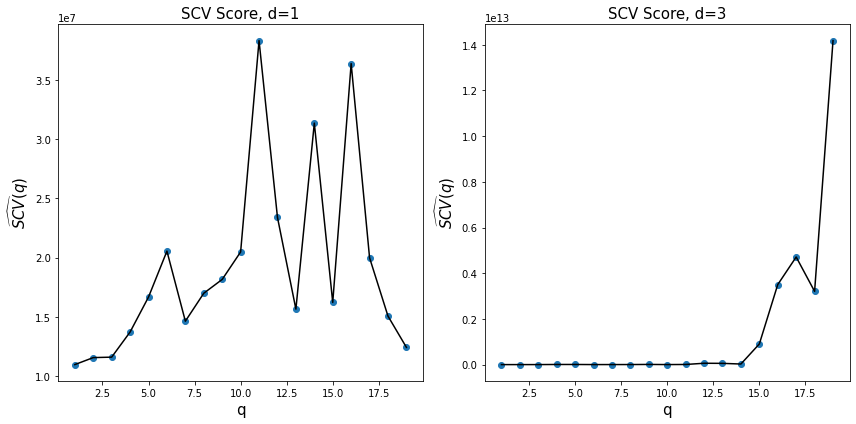

In [58]:
#d=1
#We chose to take  knots in range (1,20) and look for minima in there
knots=list(range(1,20))
#apply the GCV method to data making q vary
res1=list(map(main,[1]*len(knots),knots,['SCV']*len(knots),[data]*len(knots)))
#retrieve index of min value for residuals
ind1=np.argmin(res1)

#d=3
res2=list(map(main,[3]*len(knots),knots,['SCV']*len(knots),[data]*len(knots)))
ind2=np.argmin(res2)

print(('Optimal q in (1,20) for d = 1 is q = {}, with residuals score = {}').format(knots[ind1],res1[ind1]))
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(12,6))
ax1.scatter(knots,res1)
ax1.plot(knots,res1,color='black')
ax1.set_title(r'SCV Score, d=1',fontsize=15)
ax1.set_xlabel('q',fontsize=15)
ax1.set_ylabel(r'$\widehat{SCV}(q)$',fontsize=15)

print(('Optimal q in (1,20) for d = 3 is q = {}, with residuals score = {}').format(knots[ind2],res2[ind2]))

ax2.scatter(knots,res2)
ax2.plot(knots,res2,color='black')
ax2.set_title(r'SCV Score, d=3',fontsize=15)
ax2.set_xlabel('q',fontsize=15)
ax2.set_ylabel(r'$\widehat{SCV}(q)$',fontsize=15)

fig.tight_layout()
plt.show()

### Mallows' Cp

Optimal q in (1,20) for d = 1 is q = 18, with residuals score = 9324075.58
Optimal q in (1,20) for d = 3 is q = 19, with residuals score = 9107036.72


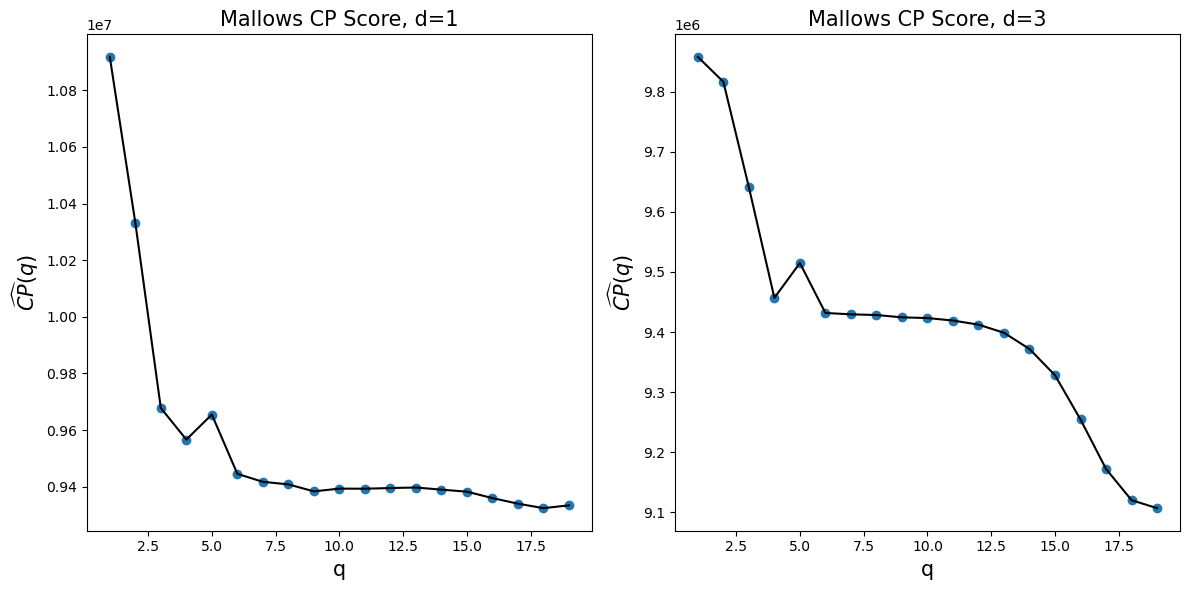

In [12]:
# for d=3 
knots=list(range(1,20))
# print(knots)
res1=list(map(main,[1]*len(knots),knots,['CP']*len(knots),[data]*len(knots)))
ind1=np.argmin(res1)

res2=list(map(main,[3]*len(knots),knots,['CP']*len(knots),[data]*len(knots)))
ind2=np.argmin(res2)

# printing both for d=1 and d=3
print(('Optimal q in (1,20) for d = 1 is q = {}, with residuals score = {}').format(knots[ind1],res1[ind1]))
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(12,6))
ax1.scatter(knots,res1)
ax1.plot(knots,res1,color='black')
ax1.set_title(r'Mallows CP Score, d=1',fontsize=15)
ax1.set_xlabel('q',fontsize=15)
ax1.set_ylabel(r'$\widehat{CP}(q)$',fontsize=15)

print(('Optimal q in (1,20) for d = 3 is q = {}, with residuals score = {}').format(knots[ind2],res2[ind2]))

ax2.scatter(knots,res2)
ax2.plot(knots,res2,color='black')
ax2.set_title(r'Mallows CP Score, d=3',fontsize=15)
ax2.set_xlabel('q',fontsize=15)
ax2.set_ylabel(r'$\widehat{CP}(q)$',fontsize=15)

fig.tight_layout()
plt.show()

It appears that the stratified cv gives almost opposite results with respect to mallows cp or gcv, we will now report a simple table and choose the best combination according to the gathered results. Clearly we have the best approach with 19 knots and a degree of 3.

In [17]:
results = [["Mallows'Cp",3,19,9107036.72],
            ["Generalized CV",3,19,9107396.91],
            ["Stratified CV",3,1,89051359.87]]
df=pd.DataFrame(results,columns=['Procedure','d','q','Score'])
df

,Procedure,d,q,Score
0,Mallows'Cp,3,19,9107036.72
1,Generalized CV,3,19,9107396.91
2,Stratified CV,3,1,89051359.87


### Final fit 

In [19]:
X=pre_processing(data.x,3,19) 
# using d=3 and q=19
plm=LinearRegression(fit_intercept=False).fit(X,data.y)
# get coefficients
c=plm.coef_
c

array([ 6.10522929e+02,  1.46917599e+01,  1.40782069e-04,  5.32685532e-04,
        1.57953803e-04, -2.53378501e-03,  1.36216112e-03, -9.94004388e-04,
        2.22643473e-03,  1.62549638e-03, -1.14751245e-03, -1.24491784e-03,
       -2.69349908e-03,  5.24060259e-03, -7.26519950e-03,  8.66642976e-03,
       -2.42075859e-03, -1.00109660e-02,  2.72051808e-02, -5.07437371e-02,
        8.44416756e-02, -1.42549104e-01,  3.69518208e-01])

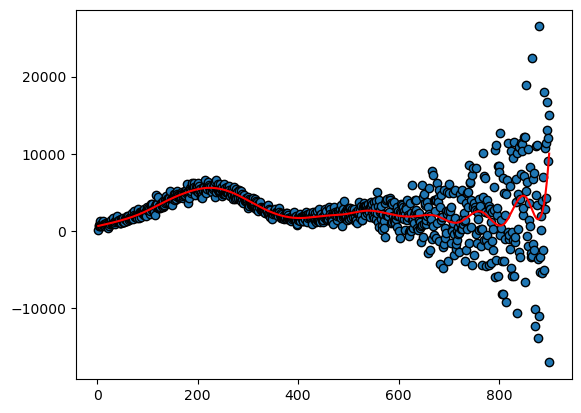

In [20]:
# plot
plt.scatter(data.x,data.y,edgecolors='black')
plt.plot(data.x,np.sum((X*c),axis=1),color='red')
plt.show()

## 1.4

In the end we will test our best fit with a polynomial regression. Choosing which degree using again GCV

In [14]:
# polynomial test
def poly_test(d,x=data.x,y=data.y):
    # fit the polynomial
    poly=np.polyfit(data.x,data.y,d)
    # get predictions on train data
    y_hat=np.polyval(poly,data.x)
    # get mse and gcv score
    mse=mean_squared_error(data.y,y_hat)
    return round(mse/((1-((d+1)/len(data.x)))**2),2)

In [25]:
# look for optimal degree between 1 and 14
ds=list(range(1,15))
scores=list(map(poly_test,ds))
ind=np.argmin(scores)
print(('Optimal d in [1,15) d = {}, with GCV score = {}').format(ds[ind],scores[ind]))

Optimal d in [1,15) d = 9, with GCV score = 9548764.95


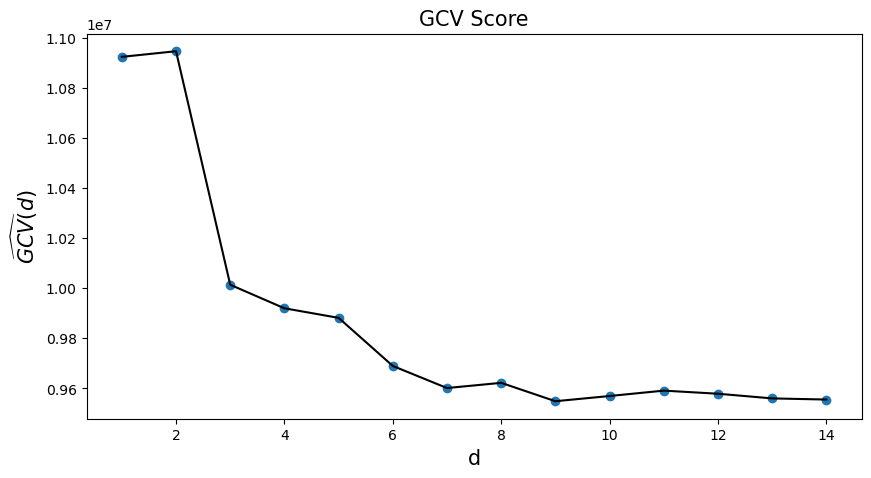

In [26]:
plt.figure(figsize=(10,5))
plt.scatter(ds,scores)
plt.plot(ds,scores,color='black')
plt.title(r'GCV Score',fontsize=15)
plt.xlabel('d',fontsize=15)
plt.ylabel(r'$\widehat{GCV}(d)$',fontsize=15)
plt.show()

In [23]:
poly=np.polyfit(data.x,data.y,9)
y_hat=np.polyval(poly,data.x)

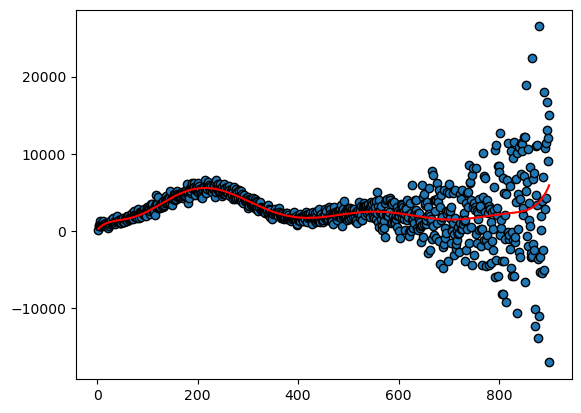

In [24]:
plt.scatter(data.x,data.y,edgecolors='black')
plt.plot(data.x,y_hat,color='red')
plt.show()

# Part 2

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

import statsmodels.api as sm
import plotly.graph_objects as go
from sklearn.model_selection import KFold as kf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import SplineTransformer

df = pd.read_csv('wmap.csv', skiprows = 400, names=["x", "y"]) # This is the DataFrame we will use.
wmap_sb = pd.read_csv('wmap.csv', delimiter = ',', nrows = 400) # Here we store the remaining rows

x = df.to_numpy(dtype=int)[:, 0]
y = df.to_numpy()[:, 1]
X = sm.add_constant(x.reshape(-1, 1))

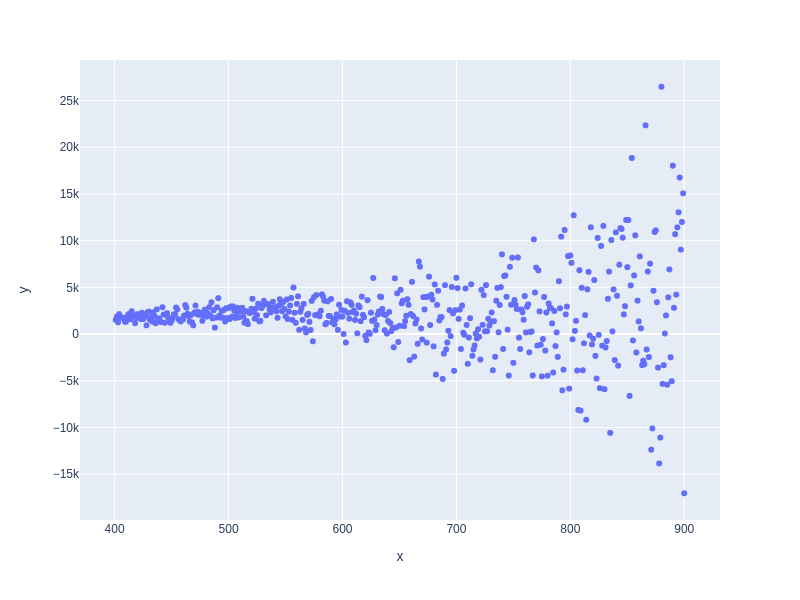

In [3]:
fig0 = px.scatter(x = x, y =y, width=800, height=600)
fig0.show(renderer="png")

## Linear fit

We consider a simple linear model:  $f(x|\theta) = \theta_0 + \theta_1x $. We fit this model using ```OLS``` from the ```statsmodels``` python package. We explore via the ```summary``` function the summary statistics. After that we evaluate the training mean squared error and store it in a variable called ```MSEp_hat``` 

In [5]:
lin_fit = sm.OLS(y, X).fit() # Computation of MSEp(theta_hat)

theta0 = lin_fit.params[0]
theta1 = lin_fit.params[1]

MSEp_hat = np.mean(lin_fit.resid ** 2) #mean of residual squared
print("MSEp_hat =", MSEp_hat)
lin_fit.summary()


MSEp_hat = 17031263.52452561


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.788
Date:                Sat, 09 Apr 2022   Prob (F-statistic):              0.182
Time:                        17:43:19   Log-Likelihood:                -4872.1
No. Observations:                 500   AIC:                             9748.
Df Residuals:                     498   BIC:                             9757.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1064.1247    853.716      1.246      0.213    -613.205    2741.455
x1             1.7134      1.281      1.337      0.182      -0.804       4.231
==============================================================================
Omnibus:                       84.541   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              774.279
Skew:                           0.392   Prob(JB):                    7.37e-169
Kurtosis:                       9.046   Cond. No.                     3.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We plot the data-scatter and add the linear fit to it. 

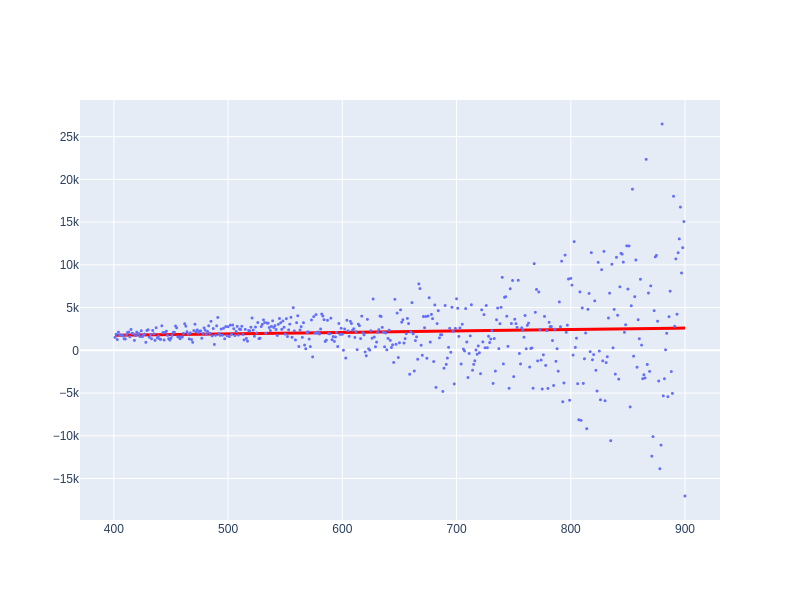

In [6]:
fig0 = px.line(x=x, y = theta0 + theta1*x)
fig0.update_traces(line_color="red", line_width=3)
fig1 = px.scatter(x=x, y=y)
fig1.update_traces(marker=dict(size=3))


fig = go.Figure(data = fig0.data + fig1.data, layout=dict(width=800, height=600))
fig.show(renderer="png")

The MSE of this linear model is of the order of $10^{7}$ while y-range is $[-17,000 +27,000]$, the square of it of the order of $10^{8}$ - so the error is of one order of magnitude smaller than the span of the data. We think that this indicates that the linear fit is in first instance a good model that captures the trend of the data but anyway does not reprensent accuratly the data as it can be seen from the plot, more assumptions are to be made to get closer to the true distribution of the data.

## Spline fit

We fit and tune using K-folds Cross Validation, from ```sklearn``` library, a spline regression model as in part I. We store in variable ```MSEnp_hat``` the in-sample mean squared error of our ```f_hat``` model, that is our spline regression model with the parameters $d,q$ that we have found during the tuning process.

In [14]:
get_spline = pre_processing #renaming the function defined in part 1 that build the splines

n_folds = 10 # Common choice of folds in K-Folds CV
q_max = 5 # Setting max number of knots
d_max = 5 # Set max number of degrees
MSEnp_hat = np.zeros((d_max,q_max)) #Initialize a Matrix with the MSEnp_hat. The element [j,k] is the MSEnp_hat of the model with d=j and q=k

#Grid search with cross validation for finding the best (such that the MSE is minimized) (d,q)
for d_i in range(d_max):
    for q_i in range(q_max):

        X_spline = get_spline(x, d_i + 1, q_i + 1) # we added 1 to the indeces to start with a linear model and one node

        folds = kf(n_folds, shuffle=True).split(X_spline, y) # the folds in the k-fold
        for train_index, test_index in folds:

            model = sm.OLS(y[train_index], X_spline[train_index]).fit()
            MSEnp_hat[d_i][q_i] += np.mean((y[test_index] - model.predict(X_spline[test_index]))**2)
            

MSEnp_hat = MSEnp_hat / n_folds #Getting the mean of every MSEnp_hat


d, q = np.unravel_index(np.argmin(MSEnp_hat, axis=None), MSEnp_hat.shape)



t_hat = MSEp_hat - MSEnp_hat[d, q] 

print("t_hat =", t_hat)

t_hat = 63670.49236572161


We add to the plot made before the nonparametric model.

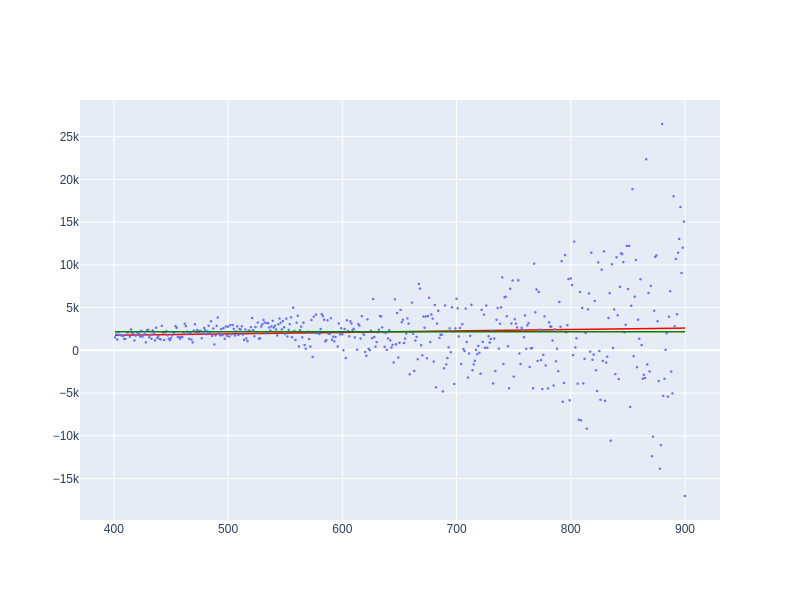

In [15]:
X_spline = get_spline(x,d=0,q=0)

f_hat = sm.OLS(y, X_spline).fit()

fig0 = px.line(x=x, y = theta0 + theta1*x)
fig0.update_traces(line_color="red", line_width=1.5)

fig1 = px.scatter(x=x, y=y)
fig1.update_traces(marker=dict(size=2.5))

fig2 = px.line(x=x, y = (X_spline @ f_hat.params))
fig2.update_traces(line_color="green", line_width=1.5)


fig = go.Figure(data = 
                fig0.data + 
                fig1.data + 
                fig2.data, 
                layout=dict(width=800, height=600)
               )

fig.show(renderer="png")

## Simulation

This function is the python version of the function ```sim_lim``` of the homework text.
It takes in input the linear model fitted on our data-set, ```lin_fit```, and ```x```, the ```x``` values of our dataset at which to simulate.
In particular the function create a new dataset with new y values: ```y_sim```. 
```y_sim``` is in built via the prediction of the fitted model ```lin_fit``` on ```X``` (where ```X``` is two columns vector, where the first is made of ones and the second is made of ```x``` , the same of the initial dataset) and via homoskedastic Gaussian noise. 
By homoskedastic Gaussian noise we mean that the noise $\epsilon_i$ has distribution $N_{0,\sigma^2}$ for all $ i $. So the standard deviation $\sigma^2$ is always the same. We take as $\sigma$ the standard deviation of the residuals of the ```lin_fit``` model.

In [25]:
def sim_lm(lin_fit=lin_fit, x=x):
    X = sm.add_constant(x.reshape(-1, 1))
    
    n = len(x)
    sigma = np.std(lin_fit.resid)
    y_sim = lin_fit.predict(X) + sigma * np.random.randn(n)
    
    x_new = np.reshape(x, (-1,1))
    y_new = np.reshape(y_sim, (-1,1))
    df = pd.DataFrame(np.concatenate([x_new,y_new], axis=1), columns=["x", "y_sim"])
    return df

In the following script we:
- simulate a new dataset from the fitted parametric model lin_fit assuming homoskedastic Gaussian Noise.
- fit the parametric model to the simulated data getting ``` MSEp_tilde[b]```
- fit and tune the nonparametric model to the simulated data getting ```MSEnp_tilde[b]```
- calculate ```t_tilde[b] = MSE_ptilde[b] - MSEnp_tilde[b]```
- calculate the p-val

In [64]:
B = 500
n_folds = 10
q_max = 5
d_max = 5

MSEnp_tilde = np.zeros(B)
MSEp_tilde = np.zeros(B)


for b in range(B):
    y_sim = sim_lm().to_numpy()[:, 1]
    
    
    res = sm.OLS(y_sim, X).fit().resid
    MSEp_tilde[b] = np.mean(res ** 2)
    
    MSEnp_tilde_sim = np.zeros((d_max, q_max))
    
    for d_i in range(d_max):
        for q_i in range(q_max):

            X_spline = get_spline(x, (d_i + 1), (q_i + 1))

            folds = kf(n_folds, shuffle=True).split(X_spline, y)
            for train_index, test_index in folds:

                model = sm.OLS(y_sim[train_index], X_spline[train_index]).fit()
                MSEnp_tilde_sim[d_i][q_i] += np.mean((y_sim[test_index] - model.predict(X_spline[test_index]))**2)

    d, q = np.unravel_index(np.argmin(MSEnp_tilde_sim, axis=None), MSEnp_tilde_sim.shape)
    MSEnp_tilde[b] = MSEnp_tilde_sim[d, q]
    
MSEnp_tilde = MSEnp_tilde / n_folds
t_tilde = MSEp_tilde - MSEnp_tilde
pval = np.sum(t_tilde > t_hat) / B
print("pval =", pval)

pval = 0.012


## Spline fit with external library

Now we will redo the same procedures as above using ```SplineTransformer``` method from ```sklearn```.

In [18]:
n_folds = 10 # Common choice of folds in K-Folds CV
q_max = 5 # Setting max number of knots
d_max = 5 # Set max number of degrees
MSEnp_hat = np.zeros((d_max,q_max)) #Initialize a Matrix with the MSEnp_hat. The element [j,k] is the MSEnp_hat of the model with d=j and q=k

#Grid search with cross validation for finding the best (such that the MSE is minimized) (d,q)
for d_i in range(d_max):
    for q_i in range(q_max):
        spline = SplineTransformer(degree = d_i+1, n_knots = q_i+3 ) #Spline transformer takes in input n_knots >=2, we are not interested in having degree 0 or n_knots 0,1,2. So we use d_i+1, q_i+3
        X_spline = spline.fit_transform(X)

        folds = kf(n_folds, shuffle=True).split(X_spline, y) 
        for train_index, test_index in folds:

            model = sm.OLS(y[train_index], X_spline[train_index]).fit()
            MSEnp_hat[d_i][q_i] += np.mean((y[test_index] - model.predict(X_spline[test_index]))**2)
            

MSEnp_hat = MSEnp_hat / n_folds #Getting the mean of every MSEnp_hat


d, q = np.unravel_index(np.argmin(MSEnp_hat, axis=None), MSEnp_hat.shape)



t_hat = MSEp_hat - MSEnp_hat[d, q]
print("t_hat =", t_hat)

t_hat = 129939.48832040653


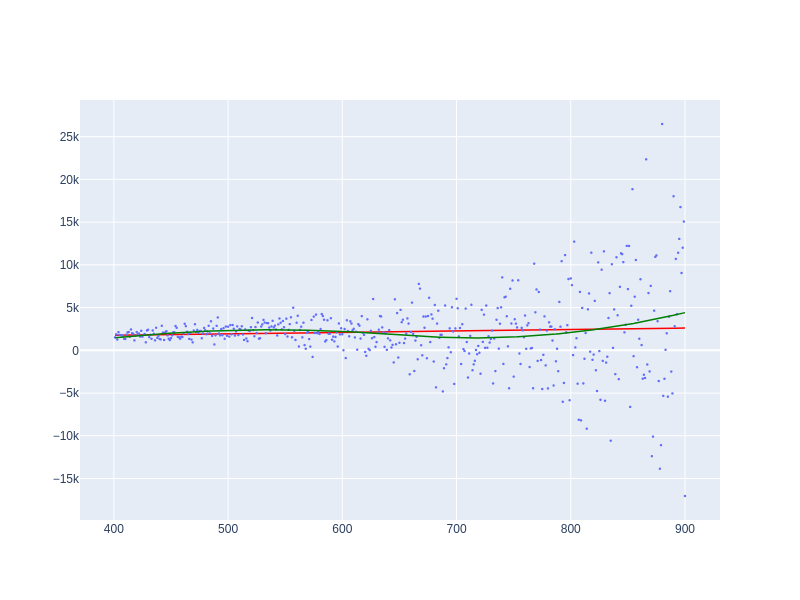

In [22]:
X_spline = SplineTransformer(degree = d+1 , n_knots = q + 3).fit_transform(X)

f_hat = sm.OLS(y, X_spline).fit()

fig0 = px.line(x=x, y = theta0 + theta1*x)
fig0.update_traces(line_color="red", line_width=1.5)

fig1 = px.scatter(x=x, y=y)
fig1.update_traces(marker=dict(size=2.5))

fig2 = px.line(x=x, y = (X_spline @ f_hat.params))
fig2.update_traces(line_color="green", line_width=1.5)


fig = go.Figure(data = 
                fig0.data + 
                fig1.data + 
                fig2.data, 
                layout=dict(width=800, height=600),
               )
fig.show(renderer="png")

In [63]:
B = 500
n_folds = 10
q_max = 5
d_max = 5

MSEnp_tilde = np.zeros(B)
MSEp_tilde = np.zeros(B)


for b in range(B):
    y_sim = sim_lm().to_numpy()[:, 1]
    
    
    res = sm.OLS(y_sim, X).fit().resid
    MSEp_tilde[b] = np.mean(res ** 2)
    
    MSEnp_tilde_sim = np.zeros((d_max, q_max))
    
    for d_i in range(d_max):
        for q_i in range(q_max):

            spline = SplineTransformer(degree = d_i+1, n_knots = q_i+3 )
            X_spline = spline.fit_transform(X)
            
            folds = kf(n_folds, shuffle=True).split(X_spline, y)
            for train_index, test_index in folds:

                model = sm.OLS(y_sim[train_index], X_spline[train_index]).fit()
                MSEnp_tilde_sim[d_i][q_i] += np.mean((y_sim[test_index] - model.predict(X_spline[test_index]))**2)

    d, q = np.unravel_index(np.argmin(MSEnp_tilde_sim, axis=None), MSEnp_tilde_sim.shape)
    MSEnp_tilde[b] = MSEnp_tilde_sim[d, q]
    
MSEnp_tilde = MSEnp_tilde / n_folds
t_tilde = MSEp_tilde - MSEnp_tilde
pval = np.sum(t_tilde > t_hat) / B
print("pval =", pval)

pval = 0.016


## Conclusion

What is the conclusion of our test? Are there secondary bumps?

The conclusion of our test is to reject $H_0$, so the linear model is not suitable. A better model is given by the splines fit.
We can see the first bump but not the second.


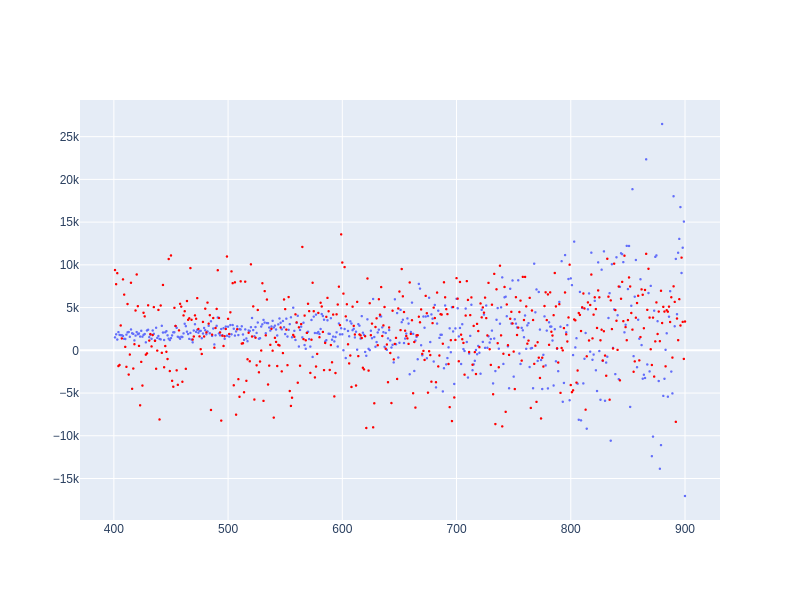

In [32]:
fig1 = px.scatter(x=x, y=y)
fig1.update_traces(marker=dict(size=2.5))
fig2 = px.scatter(x = x, y = y_sim)
fig2.update_traces(marker=dict(size=2.5,color = 'red'))
fig =go.Figure(fig1.data + fig2.data)
fig.update_layout(dict1=dict(width=800, height=600))
fig.show(renderer="png")

Do you think that all the hypotheses behind the simulation scheme adopted are reasonable for the data at hand?
More in general how robust do you think your conclusions are wrt them? Explain

We think that the homoskedastic assumption is not suitable because the data points clearly do not have the same variance; the variance increases as x increases.
Maybe adding noise with an increasing $\sigma(x)$ would have relfected better the behaviour of the data.

We think that the implemented method is robust because even if the perturbation is not suitable we rejected $H_0$ favoring a model that resembles more the official one.